# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Download Input data set and Apply summary statistics

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       #transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True,  transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True,  transform=test_transforms)

In [4]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())
train_data_mean = torch.mean(train_data)
train_data_std = torch.std(train_data)
print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', train_data_mean)
print(' - std:', train_data_std)
print(' - var:', torch.var(train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


/Users/vehere/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


# Data Transformation
performed 2 basic transformations
1. ToTensor
2. Normalize

In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(train_data_std, train_data_std ), #(0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(train_data_std, train_data_std ), #(0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


# Display a single Digit from MNIST dataset

torch.Size([64, 1, 28, 28])
torch.Size([64])


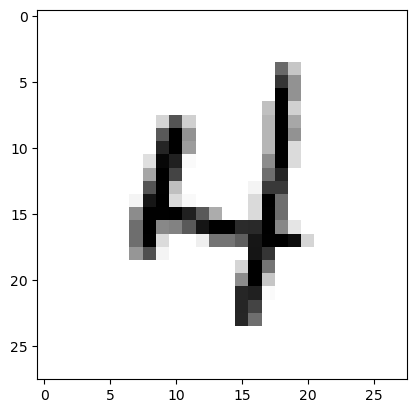

In [8]:

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

# Display an array of random images from dataset


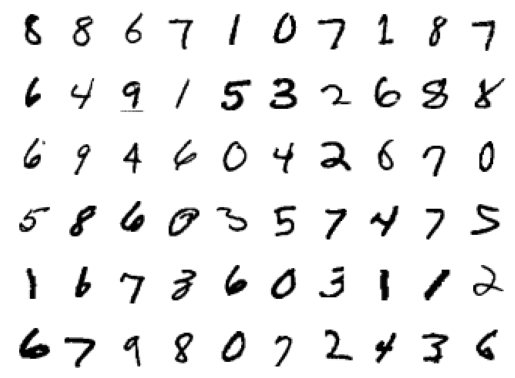

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model Params

Can't emphasize on how important viewing Model Summary is. Unfortunately, there is no in-built model visualizer, so we have to take external help

In [10]:
!pip install torchsummary
from torchsummary import summary
from model import Net2
use_cuda = torch.cuda.is_available()
device = torch.device(use_cuda if use_cuda else "cpu")
print(device)
model = Net2().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
            Conv2d-2           [-1, 16, 28, 28]           1,168
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 24, 14, 14]           3,480
            Conv2d-5           [-1, 28, 14, 14]           6,076
         MaxPool2d-6             [-1, 28, 7, 7]               0
            Conv2d-7             [-1, 24, 5, 5]           6,072
            Conv2d-8             [-1, 16, 3, 3]           3,472
            Conv2d-9             [-1, 10, 1, 1]           1,450
Total params: 21,798
Trainable params: 21,798
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 0.08
Estimated Total Size (MB): 0.35
-----------------------------------------

/Users/vehere/ERA_V2/ERA_v2.0/s7/model.py:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Train and test Net2 model

In [12]:
device = torch.device("mps")
model =  Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.014575631357729435 Batch_id=937 Accuracy=83.18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 78.28it/s]



Test set: Average loss: 0.0710, Accuracy: 9768/10000 (97.68%)

EPOCH: 1


Loss=0.03543766587972641 Batch_id=937 Accuracy=97.94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:10<00:00, 85.68it/s]



Test set: Average loss: 0.0447, Accuracy: 9851/10000 (98.51%)

EPOCH: 2


Loss=0.03573652356863022 Batch_id=937 Accuracy=98.56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:10<00:00, 90.10it/s]



Test set: Average loss: 0.0412, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.002509806538000703 Batch_id=937 Accuracy=98.89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:10<00:00, 87.18it/s]



Test set: Average loss: 0.0347, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.008393064141273499 Batch_id=937 Accuracy=99.04: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 81.56it/s]



Test set: Average loss: 0.0301, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.09877720475196838 Batch_id=937 Accuracy=99.19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:10<00:00, 88.09it/s]



Test set: Average loss: 0.0323, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.0031115072779357433 Batch_id=937 Accuracy=99.25: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 77.33it/s]



Test set: Average loss: 0.0292, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.0005630225059576333 Batch_id=937 Accuracy=99.35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:10<00:00, 85.83it/s]



Test set: Average loss: 0.0286, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.4067252278327942 Batch_id=937 Accuracy=99.39: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 84.03it/s]



Test set: Average loss: 0.0321, Accuracy: 9900/10000 (99.00%)

EPOCH: 9


Loss=7.935280882520601e-05 Batch_id=937 Accuracy=99.52: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 84.46it/s]



Test set: Average loss: 0.0315, Accuracy: 9910/10000 (99.10%)

EPOCH: 10


Loss=0.00187857320997864 Batch_id=937 Accuracy=99.54: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 83.76it/s]



Test set: Average loss: 0.0347, Accuracy: 9895/10000 (98.95%)

EPOCH: 11


Loss=0.13275644183158875 Batch_id=937 Accuracy=99.56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 85.03it/s]



Test set: Average loss: 0.0304, Accuracy: 9908/10000 (99.08%)

EPOCH: 12


Loss=0.1713777482509613 Batch_id=937 Accuracy=99.65: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 83.78it/s]



Test set: Average loss: 0.0343, Accuracy: 9899/10000 (98.99%)

EPOCH: 13


Loss=0.00010648629540810362 Batch_id=937 Accuracy=99.69: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 84.95it/s]



Test set: Average loss: 0.0351, Accuracy: 9898/10000 (98.98%)

EPOCH: 14


Loss=0.00047667717444710433 Batch_id=937 Accuracy=99.70: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:12<00:00, 76.59it/s]



Test set: Average loss: 0.0339, Accuracy: 9918/10000 (99.18%)

EPOCH: 15


Loss=1.67428188433405e-05 Batch_id=937 Accuracy=99.69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 78.34it/s]



Test set: Average loss: 0.0281, Accuracy: 9934/10000 (99.34%)

EPOCH: 16


Loss=0.0005369916325435042 Batch_id=937 Accuracy=99.77: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 82.52it/s]



Test set: Average loss: 0.0364, Accuracy: 9905/10000 (99.05%)

EPOCH: 17


Loss=0.00040981173515319824 Batch_id=937 Accuracy=99.75: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 81.56it/s]



Test set: Average loss: 0.0400, Accuracy: 9917/10000 (99.17%)

EPOCH: 18


Loss=0.0004698576231021434 Batch_id=937 Accuracy=99.79: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 83.05it/s]



Test set: Average loss: 0.0332, Accuracy: 9922/10000 (99.22%)

EPOCH: 19


Loss=0.0002249693643534556 Batch_id=937 Accuracy=99.83: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 79.62it/s]



Test set: Average loss: 0.0408, Accuracy: 9916/10000 (99.16%)



# Train Vs Test Loss Plot

In [13]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

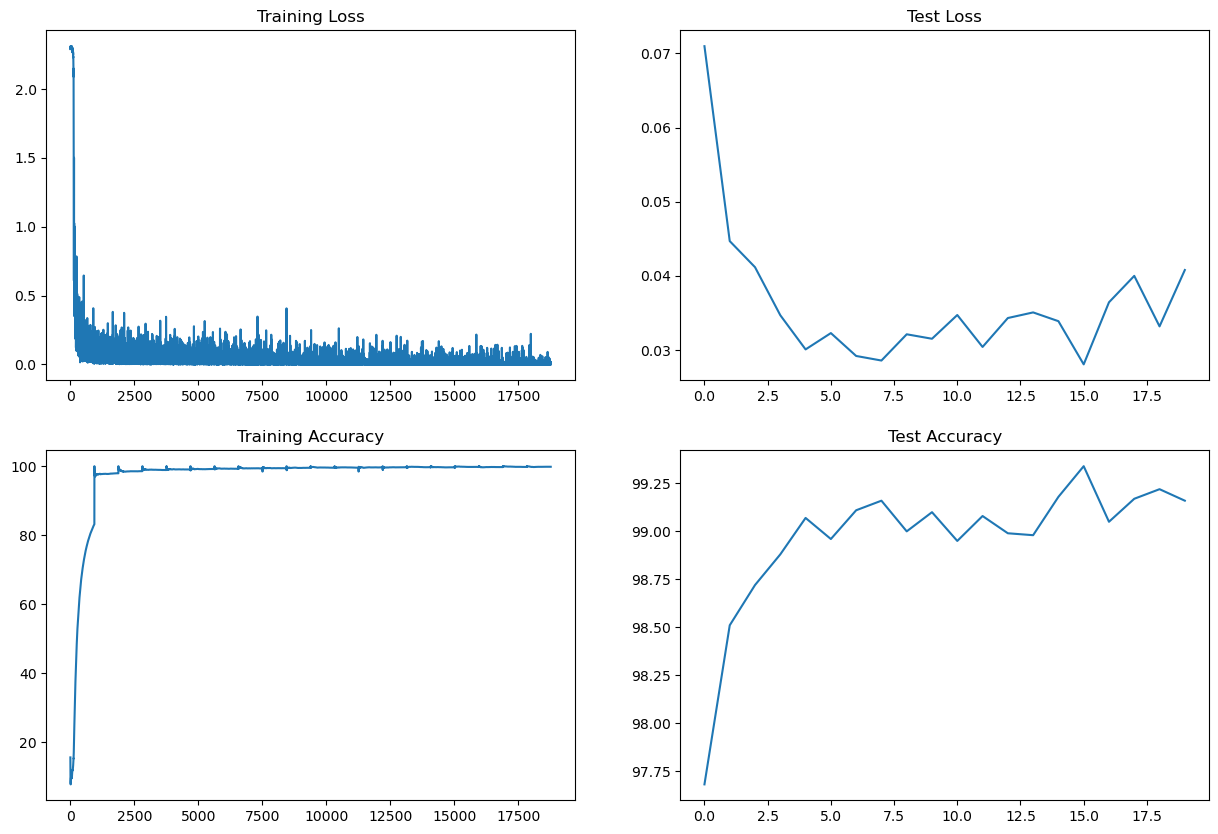

In [14]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:
* Create a light weight model (Net2) from basic Model(Net1). <br>
* Reduce Kernel size in multi-fold to reduce the overall trainable parameters <br>
* Use Max Pooling and Adaptive Average Pooling <br>
## Results:
* Parameters: 21k <br>
* Best Training Accuracy: 99.77 <br>
* Best Test Accuracy: 99.34 <br>
## Analysis:
* Net2 is roubust light weight model with 20k parameters that works well till ~99.2 to 99.3% of test accuracy and after that train and test accuracy starts dropping.<br>
* The model starts overfitting after it reached the max train accuracy of 99.7% and no further improvements is possible.<br>
* Need to apply regularization methods <br>

